In [1]:
# IMPORTS #

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict

In [2]:
# PARAMETERS #

SEASON_GAMES = 16
SIM_REPS = 100
NUM_TEAMS = 1

# Concussions per team per season (Poisson lambda)
lambda_team = 0.438  

concussion_prob_by_pos = { 
    'QB': 0.16666666666666666,  
    'RB': 0.19047619047619047,
    'WR': 0.3333333333333333,
    'TE': 0.30952380952380953,
    'K': 0.00
}

# Position buckets and data-based probabilities
positions = ['QB', 'RB', 'WR', 'TE', 'K'] 

pos_probs = [
    7/55,   # QB
    10/55,  # RB
    20/55,  # WR
    18/55,  # TE
    0/55    # K
]

# Average games missed by position 
games_missed_by_position = {
    'QB': 3,
    'RB': 2,
    'WR': 2,
    'TE': 4,
    'K': 0
}

# Probability that the position "produces" their points_loss in a game (when available)

prob_score_by_pos = {
    'QB': 0.3,
    'RB': 0.3,
    'WR': 0.3,
    'TE': 0.3,
    'K': 0.5
}
# expected points lost per game by position 
points_loss = {'QB':-3.73, 'RB':1-8.23, 'WR':-.36, 'TE':-0.16,'K':0.0}

# per-player per-game salary (median values) (NOT PLACEHOLDERS)
per_game_salary = {'QB': 600000, 'RB':158823, 'WR':142000, 'TE':121875, 'K':125000}

# points to wins conversion (NOT PLACEHOLDER)
POINTS_PER_WIN = 47.0

# optional: value per win (for revenue/valuation impact) (NOT PLACEHOLDER)
VALUE_PER_WIN = 2000000

# percent of fans not showing up when players are injured per position 
FAN_DROP_PERCENT = {'QB':0.05, 'RB':0.03, 'WR':0.02, 'TE':0.01,'K':0.005}


In [3]:
# SIMULATION #

# Random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def simulate_season():
    total_points_lost = 0.0
    total_salary_lost = 0.0
    total_fan_drop = 0.0
    
    # Simulate number of concussions for the team this season
    num_concussions = np.random.poisson(lambda_team)
    
    for _ in range(num_concussions):
        # Determine position of injured player
        injured_pos = np.random.choice(positions, p=pos_probs)
        
        # Determine games missed
        games_missed = games_missed_by_position[injured_pos]
        
        # Calculate points lost
        points_lost = points_loss[injured_pos] * games_missed
        total_points_lost += points_lost
        
        # Calculate salary lost
        salary_lost = per_game_salary[injured_pos] * games_missed
        total_salary_lost += salary_lost
        
        # Calculate fan drop
        fan_drop = FAN_DROP_PERCENT[injured_pos] * games_missed
        total_fan_drop += fan_drop
    
    return total_points_lost, total_salary_lost, total_fan_drop

# Run simulations
results = []
for sim in range(SIM_REPS):
    points_lost, salary_lost, fan_drop = simulate_season()
    results.append({
        'Simulation': sim + 1,
        'Points_Lost': points_lost,
        'Salary_Lost': salary_lost,
        'Fan_Drop': fan_drop
    })


In [4]:
# RESULTS SUMMARY #

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)
print(df_results)
print("Simulation Averages (100 seasons):")

#averages
df_averages = pd.DataFrame({
    'Metric': ['Points_Lost', 'Money_Lost', 'Fan_Drop'],
    'Average': [
        np.mean([r['Points_Lost'] for r in results]),
        np.mean([r['Salary_Lost'] for r in results]),
        np.mean([r['Fan_Drop'] for r in results])
    ]
})
print(df_averages)
print(f"On average, you can expect to loose ${np.mean([r['Salary_Lost'] for r in results]):,.2f} per season due to concussions.")

import matplotlib.pyplot as plt
# table of how likely team will loose certain amount of money
salary_losses = [r['Salary_Lost'] for r in results]
print(max(salary_losses))
df_lost = pd.DataFrame(salary_losses, columns=['Salary_Lost'])

    Simulation  Points_Lost  Salary_Lost  Fan_Drop
0            1         0.00          0.0      0.00
1            2       -28.92     635292.0      0.12
2            3         0.00          0.0      0.00
3            4        -0.64     487500.0      0.04
4            5         0.00          0.0      0.00
..         ...          ...          ...       ...
95          96         0.00          0.0      0.00
96          97        -0.72     284000.0      0.04
97          98         0.00          0.0      0.00
98          99         0.00          0.0      0.00
99         100         0.00          0.0      0.00

[100 rows x 4 columns]
Simulation Averages (100 seasons):
        Metric      Average
0  Points_Lost      -1.7501
1   Money_Lost  208460.2200
2     Fan_Drop       0.0221
On average, you can expect to loose $208,460.22 per season due to concussions.
2571500.0


In [5]:
import matplotlib.pyplot as plt

salary_losses = [r['Salary_Lost'] for r in results]
# Convert simulation list → DataFrame
df = pd.DataFrame(results)

# Define salary-loss bins (based on your min/max)
bins = [0, 250000, 500000, 1000000, 1500000, 2000000, 3000000]
labels = ["0–250k", "250k–500k", "500k–1M", "1M–1.5M", "1.5M–2M", "2M–3M"]

# Bin the losses
df['Loss_Range'] = pd.cut(df['Salary_Lost'], bins=bins, labels=labels, include_lowest=True)

# Calculate percentages
range_percentages = (
    df['Loss_Range']
    .value_counts(normalize=True) * 100
).sort_index()

# Turn into a final dataframe
percentage_df = pd.DataFrame({
    'Loss Range': range_percentages.index,
    'Percentage of Seasons (%)': range_percentages.values
})

percentage_df

,Loss Range,Percentage of Seasons (%)
0,0–250k,70.0
1,250k–500k,21.0
2,500k–1M,4.0
3,1M–1.5M,0.0
4,1.5M–2M,3.0
5,2M–3M,2.0


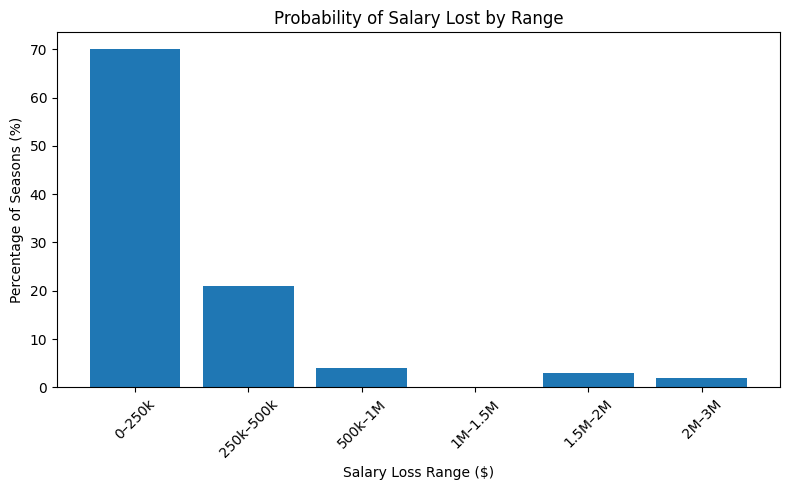

In [6]:
# Salary Loss Distribution Visualization #

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(percentage_df['Loss Range'], percentage_df['Percentage of Seasons (%)'])

plt.title("Probability of Salary Lost by Range")
plt.xlabel("Salary Loss Range ($)")
plt.ylabel("Percentage of Seasons (%)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# NFL INJURY DATA ANALYSIS SCRIPT #

# ========= DATA PARSING =========
def parse_nfl_data(csv_path):
    """
    Parse the NFL injury data from the messy CSV format.
    Returns a cleaned DataFrame with injury records.
    """
    df = pd.read_csv(csv_path)
    
    # Forward-fill team names (column B)
    if len(df.columns) > 1:
        df.iloc[:, 1] = df.iloc[:, 1].ffill()
    
    # Identify week columns
    week_cols = [col for col in df.columns if 'Week' in str(col)]
    
    injury_records = []
    
    for idx, row in df.iterrows():
        player_info = str(row.iloc[0]) if pd.notna(row.iloc[0]) else ""
        team = str(row.iloc[1]) if len(df.columns) > 1 and pd.notna(row.iloc[1]) else ""
        
        # Extract position and injury weeks from player info
        pos_match = re.search(r'\b(QB|RB|WR|TE|K)\d?\b', player_info)
        injury_match = re.search(r'WK\s*(\d+)\s*-\s*(\d+)', player_info)
        
        if pos_match and injury_match:
            position = pos_match.group(1)  # Get just QB, RB, etc.
            start_week = int(injury_match.group(1))
            end_week = int(injury_match.group(2))
            games_missed = end_week - start_week + 1
            
            # Extract player name (everything before position)
            player_name = player_info[:pos_match.start()].strip()
            
            # Find scores during injury period
            scores_during = []
            scores_after = []
            
            for week_col in week_cols:
                week_num_match = re.search(r'\d+', week_col)
                if week_num_match:
                    week_num = int(week_num_match.group())
                    score_val = str(row[week_col]) if pd.notna(row[week_col]) else ""
                    
                    # Extract numeric score
                    score_match = re.search(r'(\d+)', score_val)
                    if score_match:
                        score = int(score_match.group(1))
                        
                        if start_week <= week_num <= end_week:
                            scores_during.append(score)
                        elif week_num == end_week + 1:
                            scores_after.append(score)
            
            injury_records.append({
                'Player': player_name,
                'Team': team,
                'Position': position,
                'Start_Week': start_week,
                'End_Week': end_week,
                'Games_Missed': games_missed,
                'Scores_During_Injury': scores_during,
                'Score_First_Game_Back': scores_after[0] if scores_after else None
            })
    
    return pd.DataFrame(injury_records)


# ========= INJURY STATISTICS =========
def calculate_injury_stats(injury_df):
    """
    Calculate injury statistics by position for the simulation.
    """
    stats = {}
    
    # Group by position
    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
        pos_data = injury_df[injury_df['Position'] == pos]
        
        if len(pos_data) > 0:
            # Average games missed
            avg_games_missed = pos_data['Games_Missed'].mean()
            
            # Total injuries
            total_injuries = len(pos_data)
            
            # Average points during injury (team performance)
            all_scores = []
            for scores in pos_data['Scores_During_Injury']:
                all_scores.extend(scores)
            avg_score_during = np.mean(all_scores) if all_scores else 0
            
            # Average first game back score
            first_back_scores = pos_data['Score_First_Game_Back'].dropna()
            avg_first_back = first_back_scores.mean() if len(first_back_scores) > 0 else 0
            
            stats[pos] = {
                'total_injuries': total_injuries,
                'avg_games_missed': round(avg_games_missed, 2),
                'avg_score_during_injury': round(avg_score_during, 2),
                'avg_score_first_back': round(avg_first_back, 2)
            }
        else:
            stats[pos] = {
                'total_injuries': 0,
                'avg_games_missed': 0,
                'avg_score_during_injury': 0,
                'avg_score_first_back': 0
            }
    
    return stats


# ========= POINT CONTRIBUTION ANALYSIS =========
def calculate_points_contribution(csv_path):
    """
    Calculate the typical point contribution (and loss when injured) 
    for each position based on team scoring data.
    """
    df = pd.read_csv(csv_path)
    
    # Forward-fill team names
    if len(df.columns) > 1:
        df.iloc[:, 1] = df.iloc[:, 1].ffill()
    
    week_cols = [col for col in df.columns if 'Week' in str(col)]
    
    # Track scores during injuries and baseline scores
    position_data = defaultdict(lambda: {
        'scores_during_injury': [],
        'baseline_scores': []
    })
    
    # First pass: collect injured weeks
    injured_weeks = set()  # Track (team, week) pairs with injuries
    
    for idx, row in df.iterrows():
        player_info = str(row.iloc[0]) if pd.notna(row.iloc[0]) else ""
        team = str(row.iloc[1]) if len(df.columns) > 1 and pd.notna(row.iloc[1]) else ""
        
        injury_match = re.search(r'WK\s*(\d+)\s*-\s*(\d+)', player_info)
        pos_match = re.search(r'\b(QB|RB|WR|TE|K)\d?\b', player_info)
        
        if injury_match and pos_match:
            start_week = int(injury_match.group(1))
            end_week = int(injury_match.group(2))
            position = pos_match.group(1)
            
            for week_col in week_cols:
                week_num_match = re.search(r'\d+', week_col)
                if week_num_match:
                    week_num = int(week_num_match.group())
                    score_val = str(row[week_col]) if pd.notna(row[week_col]) else ""
                    score_match = re.search(r'(\d+)', score_val)
                    
                    if score_match:
                        score = int(score_match.group(1))
                        
                        # Track injured weeks
                        if start_week <= week_num <= end_week:
                            injured_weeks.add((team, week_num))
                            position_data[position]['scores_during_injury'].append(score)
    
    # Second pass: get baseline scores (when no injuries)
    for idx, row in df.iterrows():
        team = str(row.iloc[1]) if len(df.columns) > 1 and pd.notna(row.iloc[1]) else ""
        
        for week_col in week_cols:
            week_num_match = re.search(r'\d+', week_col)
            if week_num_match:
                week_num = int(week_num_match.group())
                score_val = str(row[week_col]) if pd.notna(row[week_col]) else ""
                score_match = re.search(r'(\d+)', score_val)
                
                if score_match and (team, week_num) not in injured_weeks:
                    score = int(score_match.group(1))
                    # This is a healthy game for this team
                    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
                        position_data[pos]['baseline_scores'].append(score)
    
    # Calculate point contributions
    results = {}
    
    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
        data = position_data[pos]
        
        if data['scores_during_injury'] and data['baseline_scores']:
            avg_with_injury = np.mean(data['scores_during_injury'])
            avg_baseline = np.mean(data['baseline_scores'])
            points_lost = avg_baseline - avg_with_injury
            
            # Probability they contribute (games where they made a difference)
            prob_contribute = min(0.95, max(0.30, (points_lost / avg_baseline) * 3))
            
            results[pos] = {
                'avg_score_with_injury': round(avg_with_injury, 2),
                'avg_baseline_score': round(avg_baseline, 2),
                'points_lost_per_game': round(points_lost, 2),
                'prob_contributes': round(prob_contribute, 2),
                'injury_samples': len(data['scores_during_injury']),
                'baseline_samples': len(data['baseline_scores'])
            }
        else:
            results[pos] = {
                'avg_score_with_injury': 0,
                'avg_baseline_score': 0,
                'points_lost_per_game': 0,
                'prob_contributes': 0.50,
                'injury_samples': 0,
                'baseline_samples': 0
            }
    
    return results


# ========= SIMULATION PARAMETERS =========
def calculate_simulation_params(injury_df, total_teams=32, seasons=3):
    """
    Calculate parameters needed for the simulation.
    """
    total_injuries = len(injury_df)
    
    # Lambda for Poisson (injuries per team per season)
    lambda_team = total_injuries / (total_teams * seasons)
    
    # Position distribution
    pos_counts = injury_df['Position'].value_counts()
    total = pos_counts.sum()
    pos_probs = {pos: pos_counts.get(pos, 0) / total for pos in ['QB', 'RB', 'WR', 'TE', 'K']}
    
    # Games missed by position
    games_missed = {}
    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
        pos_data = injury_df[injury_df['Position'] == pos]
        if len(pos_data) > 0:
            games_missed[pos] = int(round(pos_data['Games_Missed'].mean()))
        else:
            games_missed[pos] = 0
    
    params = {
        'lambda_team': round(lambda_team, 3),
        'pos_probs': pos_probs,
        'games_missed_by_position': games_missed,
        'total_injuries_observed': total_injuries
    }
    
    return params


# ========= MAIN EXECUTION =========
if __name__ == "__main__":
    
    csv_path = r"C:\Users\bella\OneDrive\Documents\PSY_341L\CompSim_Final_Project\NFL Data.csv"
    
    print("=" * 70)
    print("NFL INJURY DATA ANALYSIS - COMBINED REPORT")
    print("=" * 70)
    
    # Parse the data
    print("\n📊 Parsing injury data...")
    injury_df = parse_nfl_data(csv_path)
    print(f"✓ Found {len(injury_df)} injury records\n")
    
    # Display sample records
    print("Sample injury records:")
    print(injury_df.head(10).to_string())
    
    # Calculate injury statistics
    print("\n" + "=" * 70)
    print("INJURY STATISTICS BY POSITION")
    print("=" * 70)
    stats = calculate_injury_stats(injury_df)
    
    for pos, data in stats.items():
        print(f"\n{pos}:")
        print(f"  Total injuries: {data['total_injuries']}")
        print(f"  Avg games missed: {data['avg_games_missed']}")
        print(f"  Avg score during injury: {data['avg_score_during_injury']}")
        print(f"  Avg score first game back: {data['avg_score_first_back']}")
    
    # Calculate point contributions
    print("\n" + "=" * 70)
    print("POINT CONTRIBUTION ANALYSIS BY POSITION")
    print("=" * 70)
    
    point_results = calculate_points_contribution(csv_path)
    
    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
        print(f"\n{pos}:")
        print(f"  Avg team score when {pos} injured: {point_results[pos]['avg_score_with_injury']}")
        print(f"  Avg team score (baseline): {point_results[pos]['avg_baseline_score']}")
        print(f"  → Points lost per game: {point_results[pos]['points_lost_per_game']}")
        print(f"  → Estimated prob contributes: {point_results[pos]['prob_contributes']}")
        print(f"  Sample size: {point_results[pos]['injury_samples']} injured games, "
              f"{point_results[pos]['baseline_samples']} baseline games")
    
    # Calculate simulation parameters
    print("\n" + "=" * 70)
    print("SIMULATION PARAMETERS")
    print("=" * 70)
    params = calculate_simulation_params(injury_df)
    
    print(f"\nλ (lambda_team): {params['lambda_team']}")
    print("\nPosition probabilities:")
    for pos, prob in params['pos_probs'].items():
        print(f"  {pos}: {prob:.4f}")
    
    print("\nAverage games missed by position:")
    for pos, games in params['games_missed_by_position'].items():
        print(f"  {pos}: {games} games")
    
    print(f"\nTotal injuries observed: {params['total_injuries_observed']}")
    
    # Win probability analysis
    print("\n" + "=" * 70)
    print("WIN PROBABILITY ANALYSIS")
    print("=" * 70)
    print(f"\nAssuming 47 points needed to win on average:")
    
    for pos in ['QB', 'RB', 'WR', 'TE', 'K']:
        pts_lost = point_results[pos]['points_lost_per_game']
        baseline = point_results[pos]['avg_baseline_score']
        expected_with_injury = baseline - pts_lost
        
        print(f"\n{pos} injury:")
        print(f"  Expected score: {expected_with_injury:.1f} points")
        print(f"  Point deficit: {47 - expected_with_injury:.1f} points below win threshold")
        if expected_with_injury < 47:
            win_prob = max(0, (expected_with_injury / 47) * 0.5)
            print(f"  Est. win probability: ~{win_prob:.1%}")
    
  
    # Save cleaned data
    output_path = "cleaned_nfl_injury_data.csv"
    injury_df.to_csv(output_path, index=False)
    print(f"\n✓ Cleaned data saved to: {output_path}")
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE!")
    print("=" * 70)

NFL INJURY DATA ANALYSIS - COMBINED REPORT

📊 Parsing injury data...
✓ Found 42 injury records

Sample injury records:
           Player       Team Position  Start_Week  End_Week  Games_Missed                                Scores_During_Injury  Score_First_Game_Back
0      Jay Cutler      Bears       QB          11        12             2                                             [7, 28]                   17.0
1    Devin Hester      Bears       WR          13        14             2                                                  []                    NaN
2                      Bills       RB          11        12             2                                            [19, 13]                    NaN
3                     Browns       TE          16        17             2                                                  []                    NaN
4                  Cardinals       WR          15        17             3                                        [38, 13, 13]           